# Analysis of Sithas model run with a fall velocity of 0.00083

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rasterio as rio
import pyvista as pv
import statsmodels.api as sm
from osgeo import gdal
import datetime

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import caesarpy as cp

from pyvista import set_plot_theme
set_plot_theme('document')

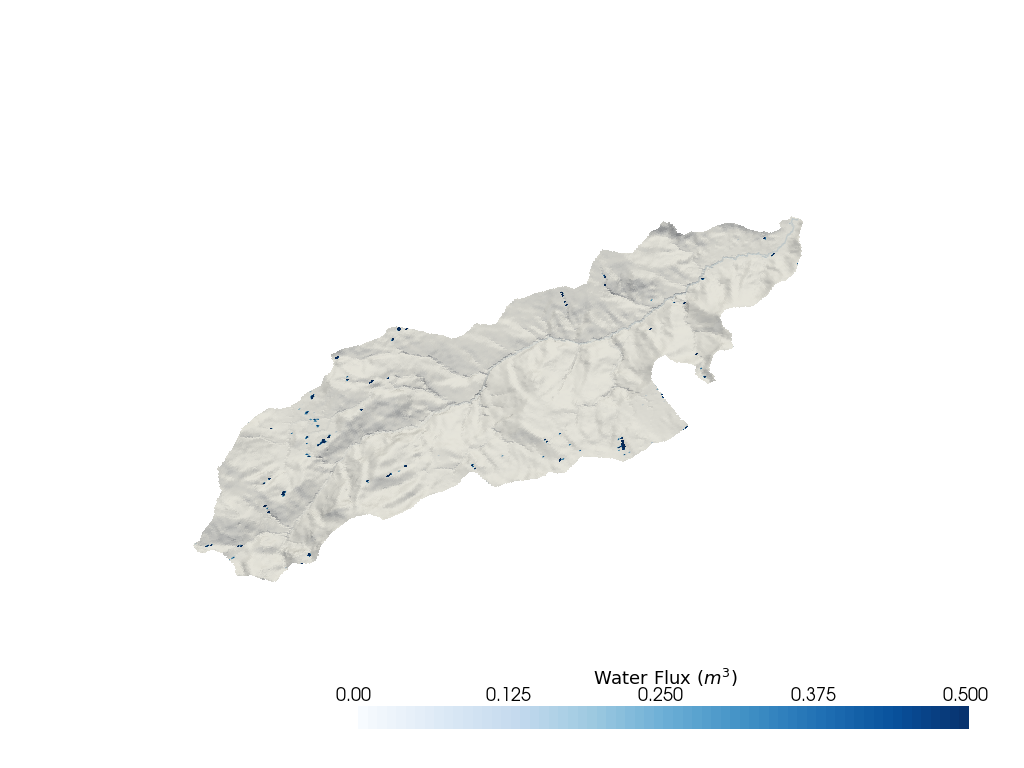

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [2]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/WaterDepths7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
water = pv.StructuredGrid(x, y, np.fliplr(data_array))
d = np.zeros_like(water.points)
d[:, 1] = water.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1], cmap='Blues', clim=[0,0.5])
p.camera_position = cpos
p.add_scalar_bar(title='Water Flux ($m^3$)')
p.show(screenshot='CL_sithas_water.png')

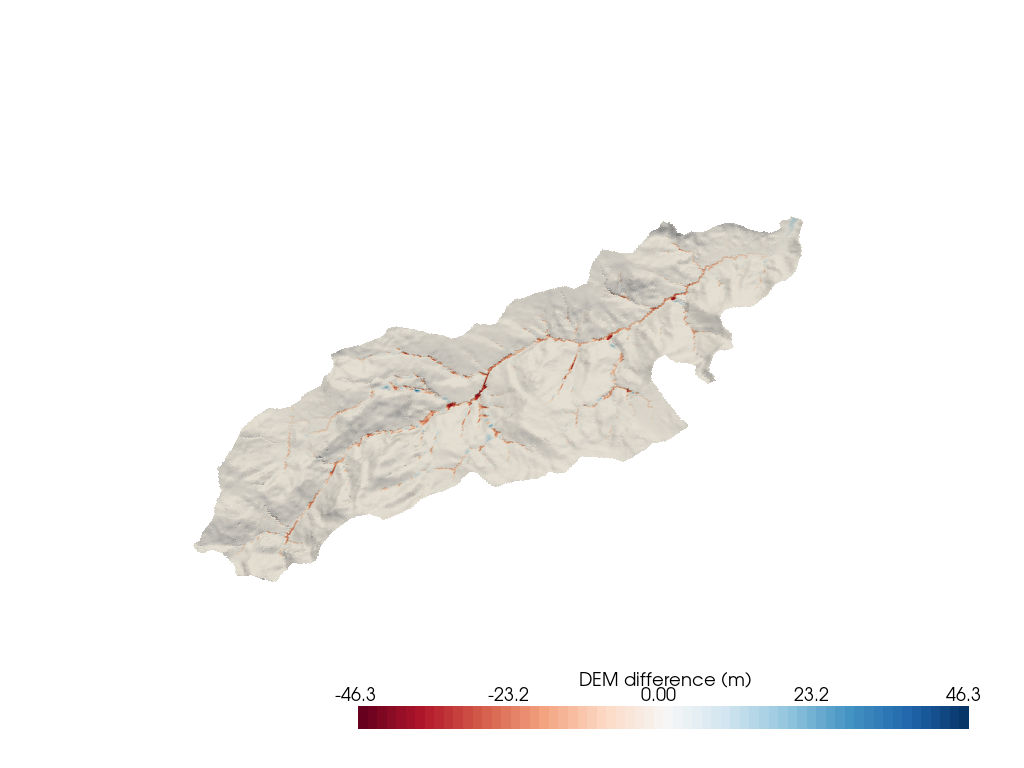

[(1069.0495742663963, 29034.111992089165, 53318.503286205276),
 (9225.0, 11075.0, 1186.6665744781494),
 (0.2969121238555084, -0.8875739108330448, 0.35221547881395754)]

In [3]:
ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Elevations7344000.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
dXY = geotransform[1]
xcorner = np.linspace(0.5*dXY, (ncols-0.5)*dXY, ncols)
ycorner = np.linspace(0.5*dXY, (nrows-0.5)*dXY, nrows)
z = np.fliplr(data_array)
x,y = np.meshgrid(xcorner, ycorner)
grid = pv.StructuredGrid(x, y, z)
d = np.zeros_like(grid.points)
d[:, 1] = grid.points[:, 2]

ascfile = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Elevations0.asc'
ncols, nrows, geotransform, data_array = cp.demio.asc2numpy(ascfile)
z0 = pv.StructuredGrid(x, y, np.fliplr(data_array))
d0 = np.zeros_like(z0.points)
d0[:, 1] = z0.points[:, 2]

cpos = [(1069.0495742663963, 29034.111992089165, 53318.503286205276),
        (9225.0, 11075.0, 1186.6665744781494),
        (0.29691212385550847, -0.887573910833045, 0.3522154788139576)]

clim = np.nanmax(np.abs(d[:,1] - d0[:,1]))
p = pv.Plotter(notebook=True)
p.add_mesh(grid, scalars=d[:,1] - d0[:,1], cmap='RdBu', clim=[-clim, clim])
p.camera_position = cpos
p.add_scalar_bar(title='DEM difference (m)')
p.show(screenshot='CL_sithas_DEMdiff.png')

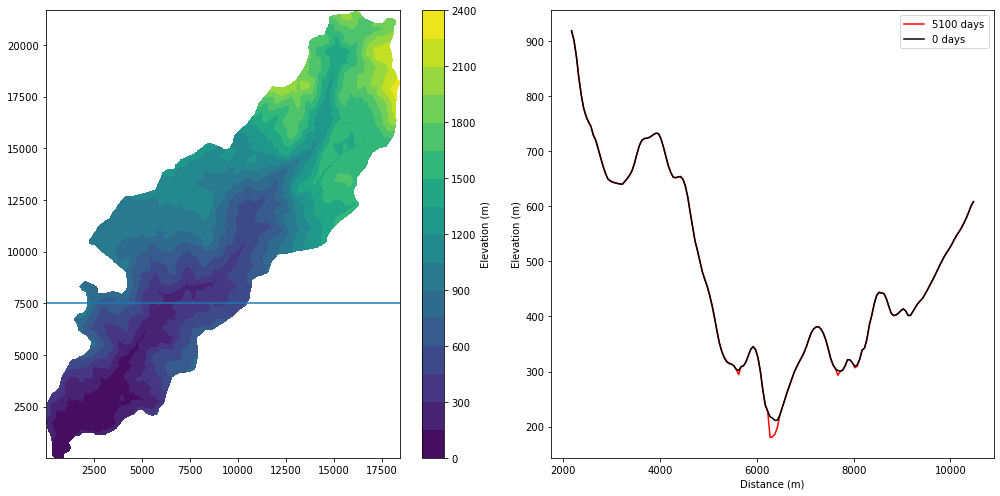

In [4]:
plt.figure(figsize=[14, 7])
plt.subplot(1,2,1)
plt.contourf(x, y, z, 20)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Elevation (m)')
plt.plot(x[150,:], y[150,:])
plt.subplot(1,2,2)
plt.plot(x[150,:], z[150,:], 'r')
zi = np.fliplr(data_array)
plt.plot(x[150,:], zi[150,:], 'k')
plt.xlabel('Distance (m)')
plt.ylabel('Elevation (m)')
plt.legend(['5100 days','0 days'])
plt.tight_layout()
plt.savefig('sithas_valleys.png')
plt.show()

<Figure size 1080x1080 with 0 Axes>

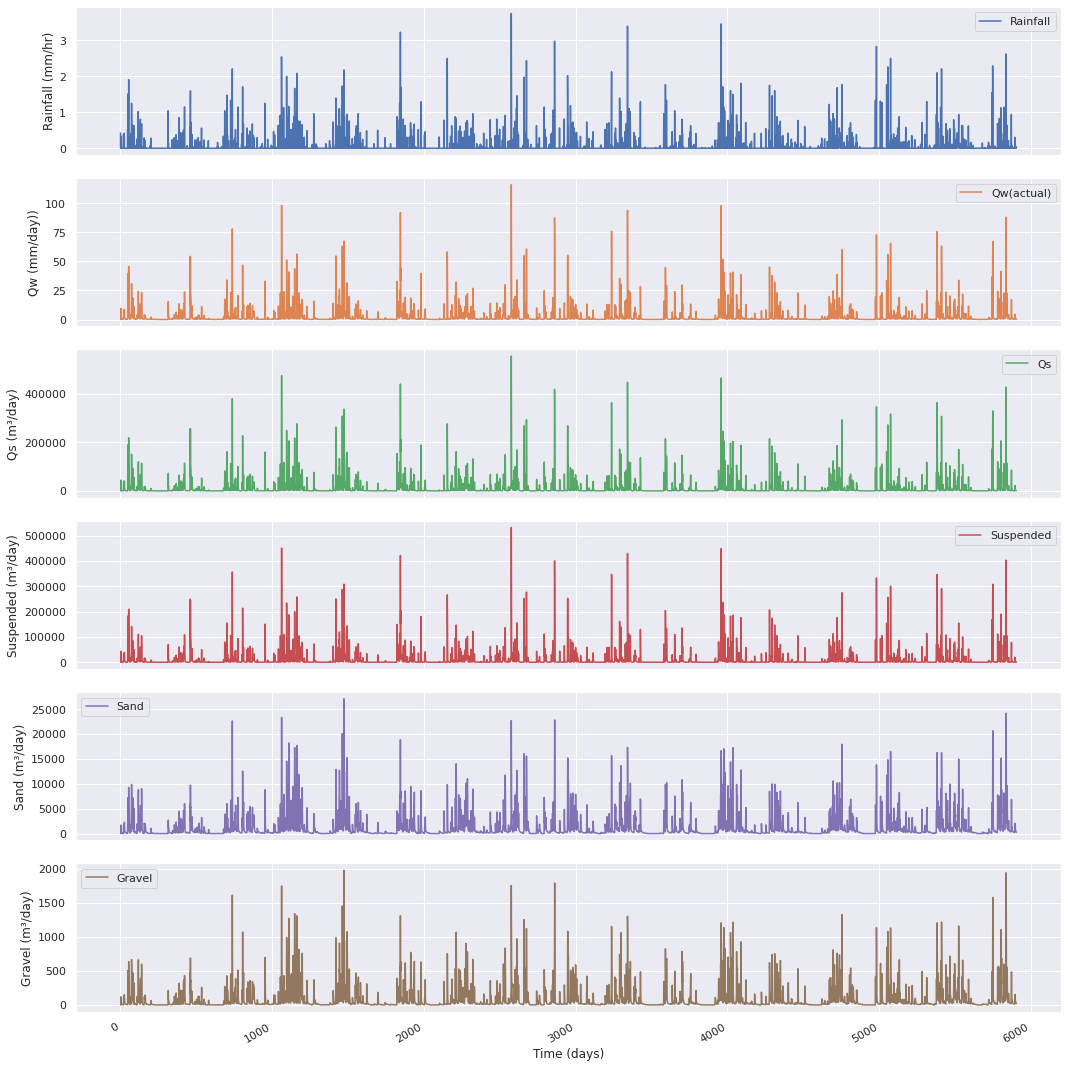

In [5]:
file = '/work/armitagj/runs/caesar-explore/ener440/sithas_0_00083vfall/results/Sithas_v7.dat'
sithas_ = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Time Step', 'Qw(actual)', 'Qw(expected)', 'Blank', 'Qs', 'Suspended', 'Sand', 'Gravel'])
file = '/work/armitagj/runs/caesar-explore/ener440/sithas/input_data/Chalkio_rain.txt'
sithas_rain = pd.read_csv(file, sep=' ', index_col=False,
                       names=['Rainfall'])
sithas_all = pd.concat([sithas_, sithas_rain], axis=1, sort=False).dropna()
sns.set(rc={'figure.figsize':(15, 15)})
plt.figure()
cols_plot = ['Rainfall', 'Qw(actual)', 'Qs', 'Suspended', 'Sand', 'Gravel']
cols_label = ['Rainfall (mm/hr)', 'Qw (mm/day))', 'Qs (m³/day)', 'Suspended (m³/day)', 'Sand (m³/day)', 'Gravel (m³/day)']
axes = sithas_all[cols_plot].plot(marker='', alpha=1, subplots=True)
i = 0
for ax in axes:
    ax.set_ylabel(cols_label[i])
    i += 1
plt.xlabel('Time (days)')
plt.tight_layout()
plt.savefig('sithas_tseries.png')
plt.show()

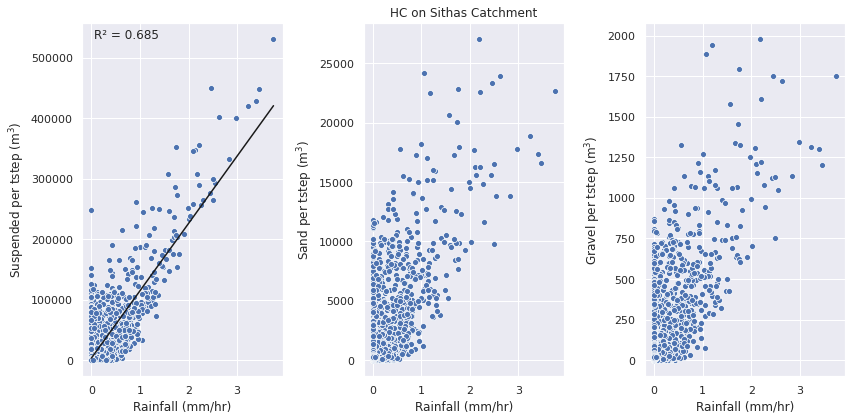

In [31]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(131)

g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Suspended'], ax=ax1)

model = sm.OLS(sithas_all['Suspended'],sm.add_constant(sithas_all['Rainfall']),missing='drop').fit()
xx = np.linspace(sithas_all['Rainfall'].min(), sithas_all['Rainfall'].max(), 2)
yy = model.params[0] + xx*model.params[1]
plt.plot(xx, yy, 'k')
plt.text(0.05, np.max(sithas_all['Suspended']), 'R² = ' + str(np.round(model.rsquared,3)))
#plt.text(0.05, np.max(sithas_all['Suspended']), 'R² = ' + str(sithas_all['Rainfall'].max()))

g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
ax2 = plt.subplot(132)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Sand'], ax=ax2)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.title('HC on Sithas Catchment')
ax3 = plt.subplot(133)
g = sns.scatterplot(sithas_all['Rainfall'], sithas_all['Gravel'], ax=ax3)
g.set_xlabel(g.get_xlabel() + ' (mm/hr)')
g.set_ylabel(g.get_ylabel() + ' per tstep (m$^3$)')
plt.tight_layout()
plt.savefig('sithas_yield_precip.png')
plt.show()

In [32]:
windows = [3, 5, 10]
for window in windows:
    
    sithas_all['Rainfall Rolling Std. ' + str(window)] = sithas_all['Rainfall'].rolling(window).std().values
    sithas_all['Rainfall Rolling Mean. ' + str(window)] = sithas_all['Rainfall'].rolling(window).mean().values
    sithas_all['Rainfall Rolling Median. ' + str(window)] = sithas_all['Rainfall'].rolling(window).median().values
    
    sithas_all['Suspended Rolling Std. ' + str(window)] = sithas_all['Suspended'].rolling(window).std().values
    sithas_all['Suspended Rolling Mean. ' + str(window)] = sithas_all['Suspended'].rolling(window).mean().values
    sithas_all['Suspended Rolling Median. ' + str(window)] = sithas_all['Suspended'].rolling(window).median().values
    
    sithas_all['Sand Rolling Std. ' + str(window)] = sithas_all['Sand'].rolling(window).std().values
    sithas_all['Sand Rolling Mean. ' + str(window)] = sithas_all['Sand'].rolling(window).mean().values
    sithas_all['Sand Rolling Median. ' + str(window)] = sithas_all['Sand'].rolling(window).median().values
    
    sithas_all['Gravel Rolling Std. ' + str(window)] = sithas_all['Gravel'].rolling(window).std().values
    sithas_all['Gravel Rolling Mean. ' + str(window)] = sithas_all['Gravel'].rolling(window).mean().values
    sithas_all['Gravel Rolling Median. ' + str(window)] = sithas_all['Gravel'].rolling(window).median().values

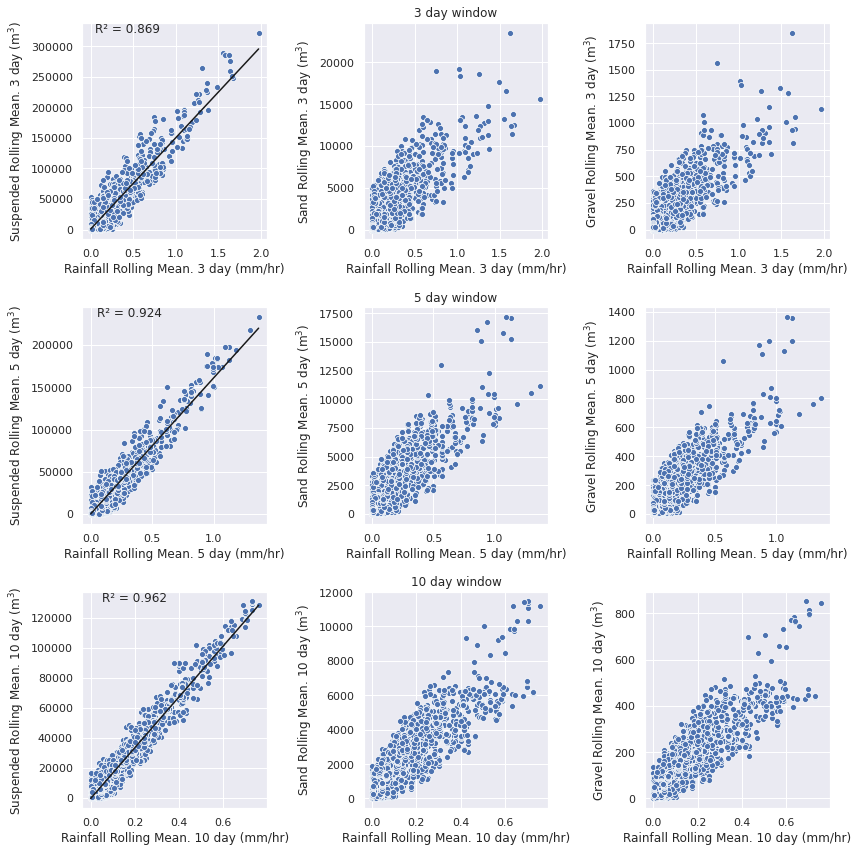

In [33]:
plt.figure(figsize=(12,12))

nplot = 330
for window in windows:
    nplot += 1
    ax1 = plt.subplot(nplot)
    
    model = sm.OLS(sithas_all['Suspended Rolling Mean. ' + str(window)],sm.add_constant(sithas_all['Rainfall Rolling Mean. ' + str(window)],),missing='drop').fit()
    xx = np.linspace(np.min(sithas_all['Rainfall Rolling Mean. ' + str(window)]), np.max(sithas_all['Rainfall Rolling Mean. ' + str(window)]), 2)
    yy = model.params[0] + xx*model.params[1]
    plt.plot(xx, yy, 'k')
    plt.text(0.05, np.max(sithas_all['Suspended Rolling Mean. ' + str(window)]), 'R² = ' + str(np.round(model.rsquared,3)))
    
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Suspended Rolling Mean. ' + str(window)], ax=ax1)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    nplot += 1
    ax2 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Sand Rolling Mean. ' + str(window)], ax=ax2)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    plt.title(str(window) + ' day window')
    nplot += 1
    ax3 = plt.subplot(nplot)
    g = sns.scatterplot(sithas_all['Rainfall Rolling Mean. ' + str(window)],
                        sithas_all['Gravel Rolling Mean. ' + str(window)], ax=ax3)
    g.set_xlabel(g.get_xlabel() + ' day (mm/hr)')
    g.set_ylabel(g.get_ylabel() + ' day (m$^3$)')
    
plt.tight_layout()
plt.savefig('sithas_yield_precip_rollmean.png')
plt.show()